# TMA 4320 Prosjekt 2
---

### Kandidatnr: 10123, 10160, 10088

In this project we explored how we could use statistic modelling in montecarlo-methods to simulate how photons in the x-ray regime propagate through matter in 1 dimension. This we did by first making a model of how a single photon propagates through a grid representing a material, where every point along the grid has a given probabilty $p$ of being absorbed. Then we generalize this simulation to take in an arbitrary amount of photons, so we can tune the simulation to arbitrary intensities in addition to attenuation coefficients. This was then used to answer different questions of how to optimally image objects with x-ray imaging techniques. Lastly we put our method to test, examining two "boxes" containing two unknown objects.

In [1]:
# Numpy to make life easy
import numpy as np
# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Increase default font size
plt.rcParams.update({'font.size': 14})

# Import for progress meter
from tqdm import tqdm, trange

In [2]:
# Various functions

# def randcheck(p):
#   z = np.random.rand()
#   if (z>p):
#     return True
#   else:
#     return False


# def propagation(N, dx, mu):
#     p = probability(dx, mu)
#     distance = 0
#     for i in range(N):
#         if not randcheck(p):
#             return distance*dx
#     distance += 1
#     return distance

# def distances(N, M, dx, mu):
#   distances = np.zeros(M)
#   for i in range(M):
#     distances[i] = propagation(N, dx, mu)
#   return distances

# def checkDistance(N, M, dx, distances):
#   N_photons = np.zeros(N)
#   for i in range(N):
#     for j in range(M):
#       if (i*dx <= distances[j]):
#         N_photons[i] += 1
#   return N_photons

Above are the functions originally used to execute problem 1. They have since been replaced, mainly by the propagation function below. These original functions were scrapped once we realized that the statistics of this problem implied that it could be solved more efficiently and equivalently using binomial distribution and the numpy.random.binomial function. These retired functions are included simply to show that we had developed the framework to solve the problem as suggested by the problem text.

In [3]:
# The analytical solution for the intensity. Eq. (4)
def analytical_intensity(I_0, mu, r): # I_0: initial intensity, mu: attenuation coeff. r: spatial variable
  return I_0*np.exp(-mu*r)

# Returns array of the estimated no. of photons left at each step
def propagation(N,M,dx, mu): # N: no. of spatial steps, M: no. of simulated photons, dx: spatial step, mu: attenuation coeff.
  # Find probability of absorption. Eq. (2).
  p = dx*mu
  # Set p = 1 if product of the attenuation coefficient and spatial step exceeds 1
  if p > 1: 
    p = 1
  
  # Create array to hold the number of photons left at each spatial step
  number_of_photons = np.zeros(N) 
  number_of_photons[0] = M # Inital number of photons
  for i in range(N-1):
    rnum = np.random.binomial(number_of_photons[i],1-p) # Removes a random number of photons using binomial distribution
    number_of_photons[i+1] = rnum
  return number_of_photons

# Returns how many photons are needed to reach the threshold energy
def photon_number_minimum(energy, M, photons): # energy: photon E, M: photons simulated, photons: photons transmitted
  energy_threshold = 10 # 10 MeV
  return np.ceil(energy_threshold/((photons/M)*energy)) # np.ceil round up to smallest whole number of photons 

# Finds energy absorbed energy when we enter the minimum no. of photons found from the above function
def absorbed_energy(energy, M, photons, photon_threshold): # energy: Photon E, M: photons simulated, photons: photons transmitted, photon_threshold: minimum no. of photons necessary
  return (1-(photons/M))*energy*photon_threshold

Justification for using the Poisson distribution: Each photon gets absorbed in a length of tissue with probability $p = \Delta x \mu$. Since it always either get transmitted (1) or absorbed (0), it is Bernoulli distributed with $p = 1 - \Delta x \mu$ as its parameter. By the assumption that each photon is independent, as the random walk model given does, we can completely equivalent to doing 1 photon at the time use the Poisson distribution with the same probability $p$ and with number of trials $n=$ number of photons that is not absorbed yet by the given step in the "walk". The only difference is that there is no reason to use for loop repeating the same calculation M times in this algorithm. This is strictly for run-rime purpose, as the functions commented out in the above codeblock always would produce the same output with the same inputs given.

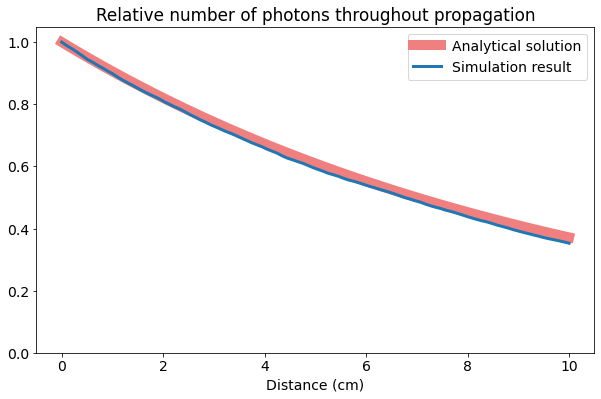

In [4]:
# Problem 1

def problem1():
  N = 100 # Number of spatial steps [1]
  M = 10000 # Number of photons [1]
  thickness = 10 # Distance of propagation [cm]
  dx = thickness/N
  mu = 0.1  # Attenuation coefficient [1/cm]
  photons = propagation(N,M,dx,mu)/M # No. of photons left at each step compared to the initial
  
  # Find analytical solution
  analytical_solution = np.zeros(N)
  for i in range(N):
    analytical_solution[i] = analytical_intensity(1, mu, i*dx)

  # Plot simulated and analytical solution
  x = np.linspace(0, thickness, N)
  plt.figure(figsize=(10, 6))
  plt.title("Relative number of photons throughout propagation")
  plt.xlabel("Distance (cm)")
  plt.ylabel("")
  plt.ylim(0,1.05)
  plt.plot(x, analytical_solution, linewidth=10, color='lightcoral', label ='Analytical solution')
  plt.plot(x, photons, linewidth=3, label ='Simulation result')
  plt.legend()
  plt.show()
problem1()

In [5]:
#txt-file reading from datafiles bones.txt and tissue.txt
mass_attenuation_coefficient_tissue = 1.02 # [g/cm^3]
mass_attenuation_coefficient_bone = 1.92 # [g/cm^3]
tissue_txt = np.loadtxt("tissue.txt",dtype=str)
bone_txt = np.loadtxt("bone.txt",dtype=str)
number_of_energylevels = 0
for word in bone_txt:
    number_of_energylevels += 1
tissue_array = np.zeros((number_of_energylevels,2))
bone_array = np.zeros((number_of_energylevels,2))
count = 0
for word in tissue_txt:
    num_eV_t = word[0][0:-1] #Second slicing does not contain ","
    num_coeff_t =float(word[1])
    tissue_array[count][0] = num_eV_t
    tissue_array[count][1] = num_coeff_t
    count += 1
count = 0
for word in bone_txt:
    num_eV_b = word[0][0:-1] #Second slicing does not contain ","
    num_coeff_b =float(word[1])
    bone_array[count][0] = num_eV_b
    bone_array[count][1] = num_coeff_b
    count += 1
bone_array[:,1] *= mass_attenuation_coefficient_bone #Is done to make a quantity with the right units for the problem
tissue_array[:,1] *= mass_attenuation_coefficient_tissue
bone_list = np.copy(bone_array[21:30]) #Values 10keV and 100keV
tissue_list = np.copy(tissue_array[21:30])
bone_list_full = np.copy(bone_array) #Whole list used in the first plot
tissue_list_full = np.copy(tissue_array)

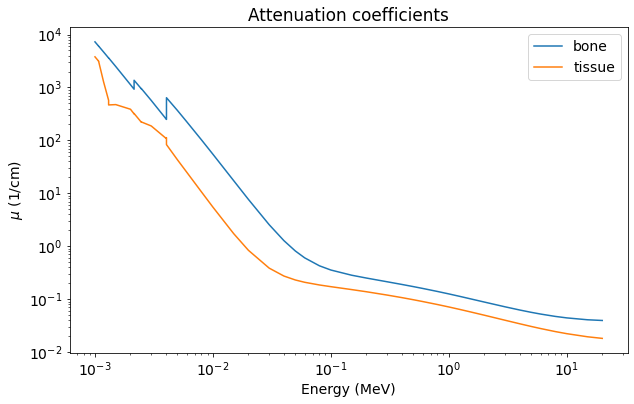

In [6]:
def plot_attenuation_coefficients():
  plt.figure(figsize=(10, 6))
  plt.title("Attenuation coefficients")
  plt.xlabel("Energy (MeV)")
  plt.ylabel(r"$\mu$ (1/cm)")
  plt.yscale("log")
  plt.xscale("log")
  plt.plot(bone_list_full[:,0],bone_list_full[:,1], label = "bone")
  plt.plot(bone_list_full[:,0],tissue_list_full[:,1], label = "tissue")
  plt.legend() 
plot_attenuation_coefficients()


<ipython-input-7-7ecbcb89a627>:20: RuntimeWarning: invalid value encountered in double_scalars
  I_diff[i] = abs(N_2[i]-N_1[i])*tissue_list[i,0]/N_1[i]#saving the total intensity for later graphing.
<ipython-input-7-7ecbcb89a627>:23: RuntimeWarning: invalid value encountered in true_divide
  contrast = (N_1-N_2)/N_1
<ipython-input-3-31e16456c805>:24: RuntimeWarning: divide by zero encountered in double_scalars
  return np.ceil(energy_threshold/((photons/M)*energy)) # np.ceil round up to smallest whole number of photons


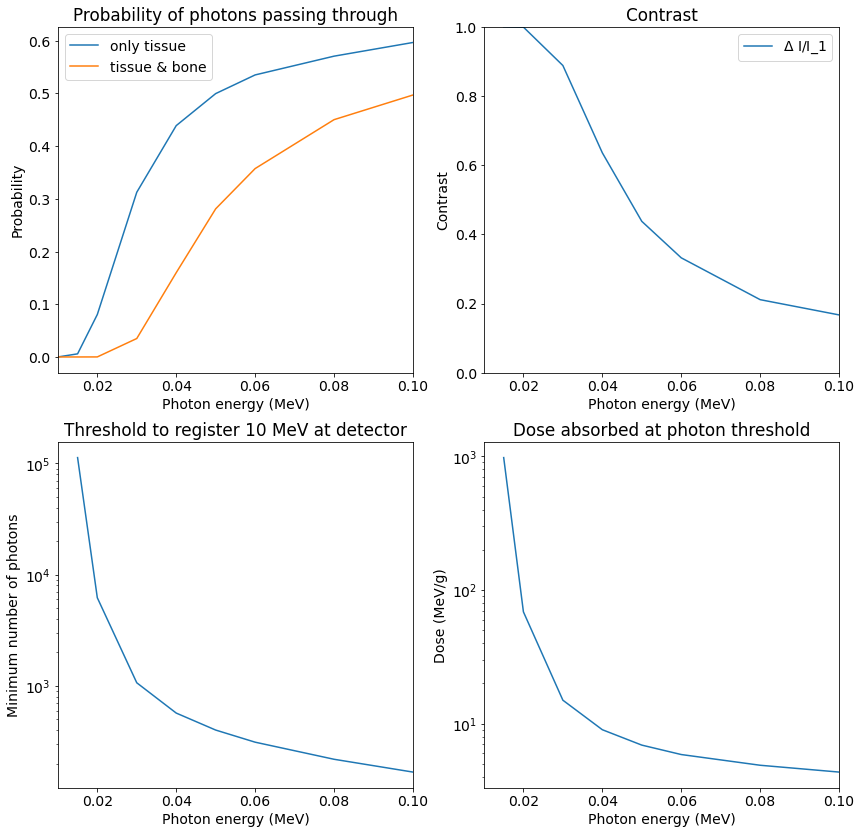

In [7]:
def problem2(bone_list, tissue_list):
  N = 1000*3 # No. of spatial steps [1] Multiple of 3 to ensure no step is skipped when propagating through bone
  M = 100000 # Simluated no. of photons [1]
  thickness = 3 # Thickness [cm]
  dx = thickness/N # Length of spatial step [cm]

  # Fill arrays holding the number of photons at each step for the two beams
  rows, columns = bone_list.shape
  N_1 = np.zeros(rows)
  N_2 = np.zeros(rows)
  I_diff = np.zeros(rows)
  max_dif = 0
  max_dif_eV = 0
  for i in range(rows): #Calling the function for the intevals tissue -> bone -> tissue.
    N_1[i] = propagation(N, M, dx, tissue_list[i,1])[-1]#Saving the amount of photons not yet absorbed by the end of
    N_21 = propagation(int(N/3), M, dx, tissue_list[i,1])[-1]#the first path(tissue), and use it as starting amount
    N_22 = propagation(int(N/3), N_21, dx, bone_list[i,1])[-1]#in the next path(bone). This done three times as seen
    N_23 = propagation(int(N/3), N_22, dx, tissue_list[i,1])[-1]
    N_2[i] = N_23
    I_diff[i] = abs(N_2[i]-N_1[i])*tissue_list[i,0]/N_1[i]#saving the total intensity for later graphing.
  
  # Find contrast. Eq. (5)
  contrast = (N_1-N_2)/N_1

  # Find minimum no. of photons required to get a signal from beam 1 for each energy
  photon_threshold_1 = np.zeros(rows)
  for i in range(rows):
    photon_threshold_1[i] = photon_number_minimum(tissue_list[i,0], M, N_1[i])
  
  # Find the energy absorbed for the two arrays
  energy_1 = np.zeros(rows)
  for i in range(rows):
    energy_1[i] = absorbed_energy(tissue_list[i,0], M, N_1[i], photon_threshold_1[i])
  energy_2 = np.zeros(rows)
  for i in range(rows):
    energy_2[i] = absorbed_energy(tissue_list[i,0], M, N_2[i], photon_threshold_1[i])
  
  # Find the dose absorbed. Eq. (6)
  density_tissue = 1.02 # [g/cm^3]
  density_bone = 1.92 # [g/cm^3]
  V = 1*1*thickness # [cm^3]
  dose = energy_1/(V*density_tissue) + energy_2/(V*((2*density_tissue+density_bone)/3)) 

  # Plotting 4 plots in a 2 by 2 grid
  fig, ax = plt.subplots(2,2, figsize = (14,14))

  ax[0,0].title.set_text("Probability of photons passing through")
  ax[0,0].set_xlabel("Photon energy (MeV)")
  ax[0,0].set_ylabel("Probability")
  ax[0,0].set_xlim([1e-2,1e-1])
  ax[0,0].plot(bone_list[:,0],N_1/M, label = "only tissue")
  ax[0,0].plot(bone_list[:,0],N_2/M, label = "tissue & bone")
  ax[0,0].legend()

  ax[0,1].title.set_text("Contrast")
  ax[0,1].set_ylabel("Contrast")
  ax[0,1].set_xlabel("Photon energy (MeV)")
  ax[0,1].set_xlim([1e-2,1e-1])
  ax[0,1].set_ylim([0,1])
  ax[0,1].plot(bone_list[:,0], contrast, label = "$\Delta$ I/I_1")
  ax[0,1].legend()

  ax[1,0].title.set_text("Threshold to register 10 MeV at detector")
  ax[1,0].set_ylabel("Minimum number of photons")
  ax[1,0].set_xlabel("Photon energy (MeV)")
  ax[1,0].set_xlim([1e-2,1e-1])
  ax[1,0].semilogy(tissue_list[:,0],photon_threshold_1, label = "Photon threshold")

  ax[1,1].title.set_text("Dose absorbed at photon threshold")
  ax[1,1].set_ylabel("Dose (MeV/g)")
  ax[1,1].set_xlabel("Photon energy (MeV)")
  ax[1,1].set_xlim([1e-2,1e-1])
  ax[1,1].semilogy(tissue_list[:,0],dose, label = "Dose")

problem2(bone_list, tissue_list)

Our results for problem 2 shows the contrast declining for higher energies, and the dose absorbed declining even more dramatically. Notice that our simulation shows that a much higher number of photons is required to reach the threshold 10 MeV intensity at the lower energies. For the lower photon energies below 20 keV, the attenuation coefficients are so high that our simulation simply has zero photons propagating through the medium. 

There seems to be a situation where one of the lower energies is right on the edge to where it sometimes lets through some photons, and other times none. Beware of this, as running the simulation multiple times will give you two somewhat different looking results. One where this point is defined and another where it is not.

There will be a trade-off between a low dose and a high contrast. Going for low energies is something we would really question, as the dose is very high whilst the contrast is not necessarily that much better. Also you actually risk having so few photons passing through, that the theoretical high contrast might not necessarily lead to a high quality image as the sample size is too low. Any photon energy beyond 50 keV gives comparable contrast, and the dose is overall so low that the strain on the radiated tissue can be considered minimal. This would therefore be our recommended choice.

In [8]:
# Loading all objects from the files provided
test_obj =np.load("test_array.npy")

object1_20 = np.load("object1_20keV.npy")
object1_50 = np.load("object1_50keV.npy")
object1_100 = np.load("object1_100keV.npy")
object2_25 = np.load("object2_25keV.npy")
object2_50 = np.load("object2_50keV.npy")
object2_75 = np.load("object2_75keV.npy")

x,y,z = object1_20.shape

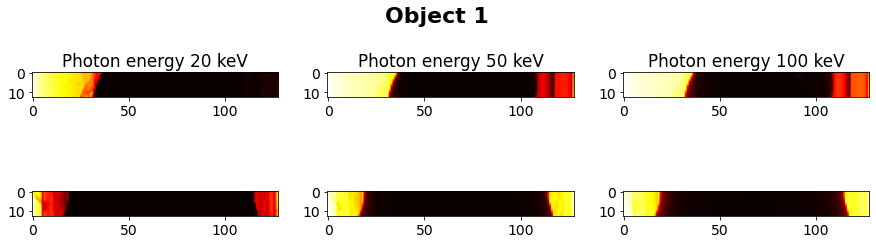

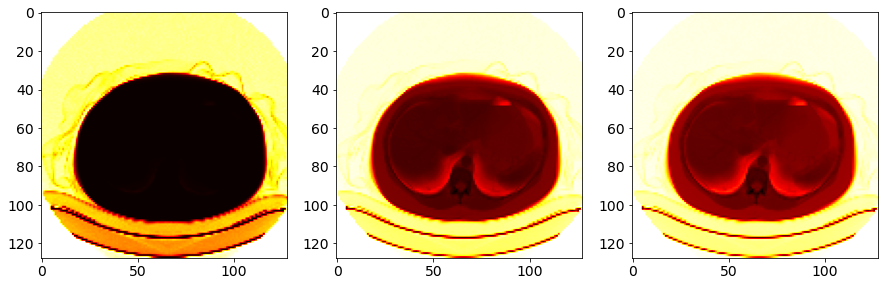

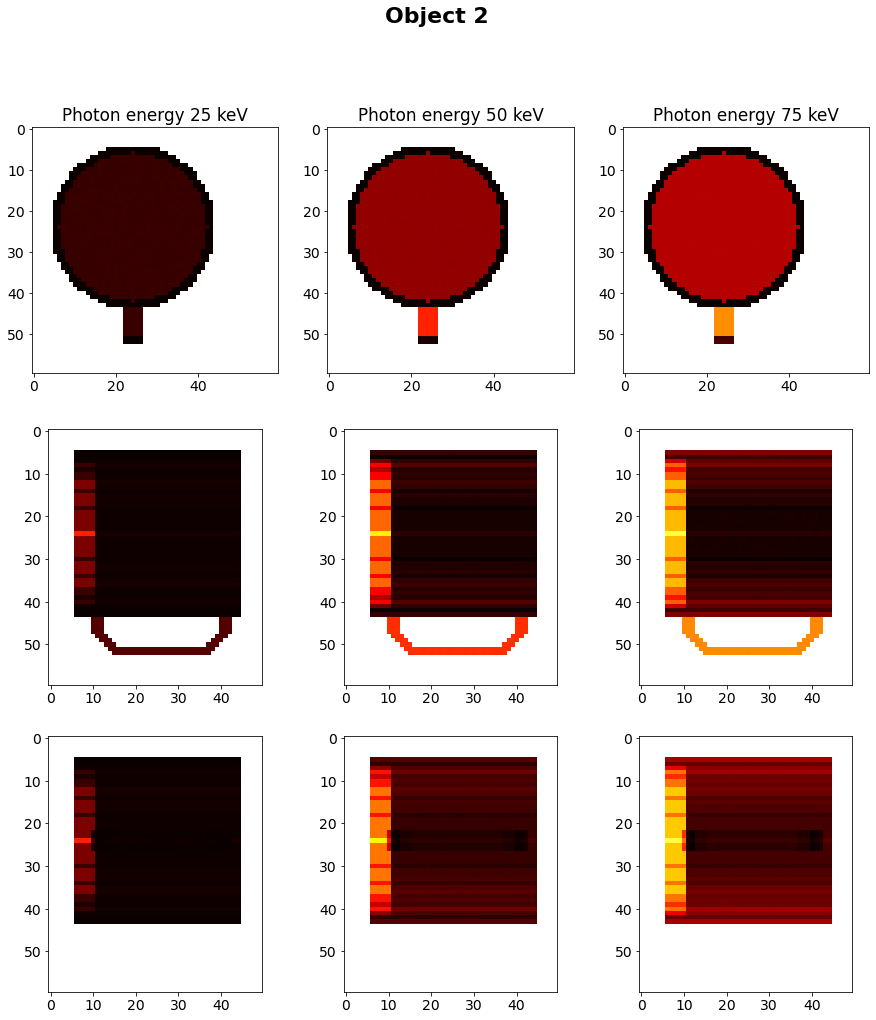

In [9]:
def propagate_object(obj,dim_obj,M):#M = number of photons
    x,y,z = obj.shape
    dx,dy,dz = dim_obj[0]/x,dim_obj[1]/y,dim_obj[2]/z
    Ixy = np.zeros((x,y))
    Ixz = np.zeros((x,z))
    Iyz = np.zeros((y,z))
    """For xy plane"""
    for i in range(x):
        for j in range(y):#these two first loops iterates over the grid that is on side of the object
            photons_left = M
            for k in range(z):#This lopp calls the function every step because the coefficient of attenuation differs
                photons_left = propagation(2, photons_left, dz, obj[i,j,k])[-1]#the 2 is there because the
                #propagation function includes the first step in the array it returns
            Ixy[i][j] = photons_left#the total transmitted amount of photons on the sensor at the other end
    """For xz plane"""
    for i in range(x):#identical to the former only with different indexes
        for k in range(z):
            photons_left = M
            for j in range(y):
                photons_left = propagation(2, photons_left, dy, obj[i,j,k])[-1]
            Ixz[i][k] = photons_left
    """For yz plane"""
    for j in range(y):#identical to the former only with different indexes
        for k in range(z):
            photons_left = M
            for i in range(x):
                photons_left = propagation(2, photons_left, dx, obj[i,j,k])[-1]
            Iyz[j][k] = photons_left
    return Ixy,Ixz,Iyz

# Run all imaging operations
ob1_20_x,ob1_20_y,ob1_20_z = propagate_object(object1_20,np.array([6.5,44.6,44.6]),1000000)
ob1_50_x,ob1_50_y,ob1_50_z = propagate_object(object1_50,np.array([6.5,44.6,44.6]),1000000)
ob1_100_x,ob1_100_y,ob1_100_z = propagate_object(object1_100,np.array([6.5,44.6,44.6]),1000000)
ob2_25_x,ob2_25_y,ob2_25_z = propagate_object(object2_25,np.array([12,12,10]),1000000)
ob2_50_x,ob2_50_y,ob2_50_z = propagate_object(object2_50,np.array([12,12,10]),1000000)
ob2_75_x,ob2_75_y,ob2_75_z = propagate_object(object2_75,np.array([12,12,10]),1000000)

# Just loads of plotting functions. Using three different subplots as 
# this was deemed the easiest given the different dimensions of the figures
fig, ax = plt.subplots(2,3, figsize = (15,4))
fig.suptitle('Object 1', fontsize=22, fontweight='bold')
ax[0,0].title.set_text("Photon energy 20 keV")
ax[0,1].title.set_text("Photon energy 50 keV")
ax[0,2].title.set_text("Photon energy 100 keV")

ax[0,0].imshow((ob1_20_x),cmap='hot')
ax[0,1].imshow((ob1_50_x),cmap='hot')
ax[0,2].imshow((ob1_100_x),cmap='hot')

ax[1,0].imshow((ob1_20_y),cmap='hot')
ax[1,1].imshow((ob1_50_y),cmap='hot')
ax[1,2].imshow((ob1_100_y),cmap='hot')


fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow((ob1_20_z),cmap='hot')
ax[1].imshow((ob1_50_z),cmap='hot')
ax[2].imshow((ob1_100_z),cmap='hot')

fig, ax = plt.subplots(3,3, figsize = (15,16))
fig.suptitle('Object 2', fontsize=22, fontweight='bold')
ax[0,0].title.set_text("Photon energy 25 keV")
ax[0,1].title.set_text("Photon energy 50 keV")
ax[0,2].title.set_text("Photon energy 75 keV")

ax[0,0].imshow((ob2_25_x),cmap='hot')
ax[0,1].imshow((ob2_50_x),cmap='hot')
ax[0,2].imshow((ob2_75_x),cmap='hot')

ax[1,0].imshow((ob2_25_y),cmap='hot')
ax[1,1].imshow((ob2_50_y),cmap='hot')
ax[1,2].imshow((ob2_75_y),cmap='hot')

ax[2,0].imshow((ob2_25_z),cmap='hot')
ax[2,1].imshow((ob2_50_z),cmap='hot')
ax[2,2].imshow((ob2_75_z),cmap='hot')

In the images above we can see that the different rays produce different quality images given the same amount of photons entered. The perceived difference in contrast between the 20/25keV and 50keV images, and the difference in contrast between the 50keV and 75/100keV images varies. The difference between the first two is much more stark than for the last two.

As to what the objects resemble, object 1 seems to be of some kind of organ. Our best guess is that it is a cross section of a kidney. Object 2 on the other hand gives a much more obvious rendering of a coffee mug.

Note that when we looked at the highest energy rays, it did not get much clearer. This leads to the conclusion that the highest energy photons might be overkill. Since the 20/25keV gives a bad contrast, using the 50keV for these objects is probably the single best choice out of the three levels of energies. Also though important to consider is that all imaging was done with the same number of simulated photons. Maybe the higher energy images really could make do with a lower number of input photons. Additionally there is always the considerations of what dose the object in question can handle. Ie. is it alive or dead, susceptible to being damaged by x-rays etc. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=678a8450-108f-4148-bada-dd842a43ef5b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>